In [1]:
import sys
import os
import random
import numpy as np
import datetime

import torch
import torch.nn as nn
from torch import autograd
from tqdm.auto import tqdm
from torchvision import transforms
# from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)

import optuna
from optuna.trial import TrialState
import mlflow

import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
import matplotlib.animation as animation
from IPython.display import HTML # to embed html in the Ipython output

sys.path.append("../src/models/")
from Generator import OptGen
from Discriminator import OptDis
from utility_functions import normalizeRGB
from utility_functions import weights_init
from OptimisationFunctions import suggest_hyperparameters, trainModel, test, objective, gradient_penalty

%matplotlib inline

%load_ext autoreload
%autoreload 2

# 1. Set the parameters

In [17]:
cadastralRoot = '../../cadastralExport' # Root directory for cadastral images
workers = 2 # Number of workers for dataloader
batch_size = 64 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 500 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
lambda_gradient_penality = 0.2 # to adjust the Wasserstein distance with interpolation between real and fake data
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## 1.1 Utility Functions

In [42]:
def generate_random_labels(batch_size: int, labels_size: int):
    
    """
    this function generates a flat tensor with length labels_size * batch_size,
    so that the sum of each labels per batch equals one 
    """
    
    labels = [] # torch.empty(size = labels_size * batch_size) #np.empty(labels_size * batch_size) # torch.zeros(labels_size * batch_size)
    for batch in range(batch_size):
        new_labels = [a for a in np.random.dirichlet(np.ones(labels_size), size=1)]
        labels.append([el for el in new_labels])
    labels = torch.tensor(labels).view(-1)
    return labels        

In [46]:
s = generate_random_labels(batch_size=batch_size, labels_size=3)

# 2. Load Dataset

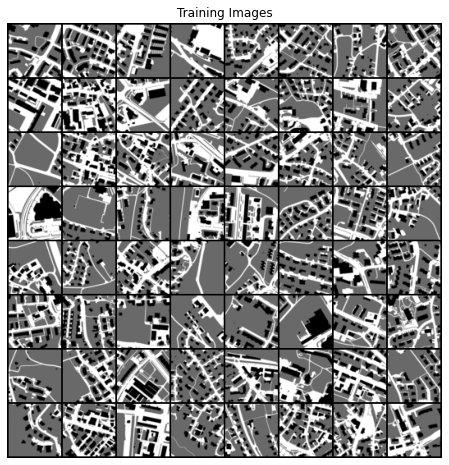

In [48]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRoot + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRoot + '/.ipynb_checkpoints')

Cad_dataset = dset.ImageFolder(root=cadastralRoot,
                           transform=transforms.Compose([
                               transforms.CenterCrop(image_size * 12),
                               transforms.Resize(image_size),
                               # transforms.RandomCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
Cad_dataloader = torch.utils.data.DataLoader(Cad_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
Cad_real_batch = next(iter(Cad_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(Cad_real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

# 3. Generator for Conditional GAN

In [59]:
# 5. Generator Class
class CondGen(nn.Module):
    def __init__(self, nz:int, num_conv_layers: int, drop_conv2: float, labels_numb: int):
        """
        This is the generator class for conditional GAN
        The input params are: 
            nz: dimension of the input noise z
            num_conv_layers: number of convolutional layers, between 3 and 6
            drop_conv2: probabiltity of the dropout for the dropout layer
            labels_numb: number of labels for the conditional distributions
        The output is a batch of images with 3 channels and resolution 64x64
        
        """
        super(CondGen, self).__init__()
        self.ngpu = torch.cuda.device_count()
        self.drop_conv2 = drop_conv2
        self.nz = nz
        self.labels_numb = labels_numb
        self.num_filters = [3] 
        self.num_filters.extend([2**(i+6) for i in range(num_conv_layers-1)])
        self.strides = [2]
        self.paddings = [1]
        self.kernelSizes = [4]
        self.out_size = []
        if num_conv_layers == 3:
            self.strides.extend([2,2])
            self.paddings.extend([0,0])
            self.kernelSizes.extend([14,10])
        if num_conv_layers == 4:
            self.strides.extend([2,2,2])
            self.paddings.extend([1,0,0])
            self.kernelSizes.extend([4,6,6])
        if num_conv_layers == 5:
            self.strides.extend([2,2,2,2])
            self.paddings.extend([1,1,1,0])
            self.kernelSizes.extend([4,4,4,4])
        if num_conv_layers == 6:
            self.strides.extend([2,2,2,2,2])
            self.paddings.extend([1,1,1,1,1])
            self.kernelSizes.extend([4,4,4,4,4])
        # self.out_size = []
        # same scheme as for DNet, but inverted
        self.num_filters.reverse()
        self.strides.reverse()
        self.paddings.reverse()
        self.kernelSizes.reverse()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution with dimensions c=nz + batch_size * labels_numb, h=1, w=1
            # output size: (2**6) x 4 x 4 O=(I-1)*s+k-2p
            nn.ConvTranspose2d(in_channels=self.nz + self.labels_numb, #deconvolution!
                               out_channels=self.num_filters[0], #ngf * 8, 
                               kernel_size=self.kernelSizes[0], 
                               stride=self.strides[0], 
                               padding=self.paddings[0], 
                               bias=False), # (1-1)*1+4-2*0=4
            nn.BatchNorm2d(self.num_filters[0]),
            nn.ReLU(True)
        )
        self.out_size.append([self.num_filters[0], (1-1)*self.strides[0]+self.kernelSizes[0]-2*self.paddings[0]])
        self.num_modules = 3
        for i in range(1, num_conv_layers):
            self.main.add_module(str(4*i-1)+"): TransConv_"+str(i+1), nn.ConvTranspose2d(in_channels=self.num_filters[i-1],
                                                            out_channels=self.num_filters[i],
                                                            kernel_size=self.kernelSizes[i],
                                                            stride=self.strides[i],
                                                            padding=self.paddings[i],
                                                            bias=False))
            self.out_size.append([self.num_filters[i], (self.out_size[i-1][1]-1)*self.strides[i]+self.kernelSizes[i]-2*self.paddings[i]])
            self.num_modules += 1
            if i + 1 < num_conv_layers:
                self.main.add_module(str(4*i)+"): DropOut_" + str(i+1), nn.Dropout2d(p=self.drop_conv2))
                self.main.add_module(str(1+4*i)+"): BatchNorm_" + str(i+1), nn.BatchNorm2d(self.num_filters[i]))
                self.main.add_module(str(2+4*i)+"): ReLU_" + str(i+1), nn.ReLU(True))
                self.num_modules += 3
            
        self.main.add_module(str(self.num_modules), nn.Tanh()) # not sigmoid
        ## print(f"Progression of the sizes in the deconvolution: {self.out_size}")
    
    def forward(self, z, labels):
        '''here z and labels are combined in the input for main'''
        z = z.view(-1, self.nz)
        c = labels.view(-1, self.labels)
        x = torch.cat([z, c], 1)
        return self.main(x)

In [60]:
netG = CondGen(nz=nz, num_conv_layers=3, drop_conv2=0.5, labels_numb=3).to(device)
netG.apply(weights_init)
print(netG)

CondGen(
  (main): Sequential(
    (0): ConvTranspose2d(103, 128, kernel_size=(10, 10), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(128, 64, kernel_size=(14, 14), stride=(2, 2), bias=False)
    (4): DropOut_2): Dropout2d(p=0.5, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): Tanh()
  )
)


# 4. Conditional Discriminator

In [ ]:
class CondDis(nn.Module):
    def __init__(self, num_conv_layers:int, labels: list[float]):
        """
        This is the discriminator class for the conditional discriminator
        Params
        num_conv_layers: number of convolutional layers, domain from 3 to 6
        labels: list of 3 float with the frequency of each entity building, roads, other 
        The output is a tensor with a critic on each image
        
        """
        super(CondDis, self).__init__()
        self.ngpu = torch.cuda.device_count()
        self.num_filters = [2**(i+6) for i in range(num_conv_layers-1)]
        self.num_filters.append(1)
        self.strides = [2]
        self.paddings = [1]
        self.kernelSizes = [4]
        self.numberChannels = 3 # could be an input
        self.out_size = []
        self.labels = labels
        if num_conv_layers == 3:
            self.strides.extend([2,2])
            self.paddings.extend([0,0])
            self.kernelSizes.extend([14,10])
        if num_conv_layers == 4:
            self.strides.extend([2,2,2])
            self.paddings.extend([1,0,0])
            self.kernelSizes.extend([4,6,6])
        if num_conv_layers == 5:
            self.strides.extend([2,2,2,2])
            self.paddings.extend([1,1,1,0])
            self.kernelSizes.extend([4,4,4,4])
        if num_conv_layers == 6:
            self.strides.extend([2,2,2,2,2])
            self.paddings.extend([1,1,1,1,1])
            self.kernelSizes.extend([4,4,4,4,4])
        
        # Add softmax layer to learn from the weights
        self.elaborateWeights(self):
            return(nn.Softmax(torch.tensor(self.labels).to(device)))
        
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64 -> output nc = 2**6 x 32 x 32
            nn.Conv2d(in_channels=self.numberChannels, 
                      out_channels=self.num_filters[0], 
                      kernel_size=self.kernelSizes[0], 
                      stride=self.strides[0], 
                      padding=self.paddings[0], 
                      bias=False), # (64-4+2)/2 + 1=32
            nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_conv_layers):
            # input is nc=(2**(i+5) x 32 x 32 -> output nc = 2**(i+6) x 32*2**(-i) x 32*2**(-i)
            self.main.add_module(str(3*i-1)+"): Conv_"+str(i+1), nn.Conv2d(in_channels=self.num_filters[i-1],
                                                            out_channels=self.num_filters[i],
                                                            kernel_size=self.kernelSizes[i],
                                                            stride=self.strides[i],
                                                            padding=self.paddings[i],
                                                            bias=False))
            if i + 1 < num_conv_layers: 
                self.main.add_module(str(3*i)+"): BatchNorm_" + str(i+1), nn.BatchNorm2d(self.num_filters[i]))
                self.main.add_module(str(1+3*i)+"): LeakyReLU_" + str(i+1), nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        # adding class inputs
        
        
        # NO ACTIVATION FUNCTION AT THE END: the idea is that the output domain for D is richer and can give a richer critict
        # avoiding local minima for G
        
        # self.main.add_module(str(3*i)+"): Sigmoid", nn.Sigmoid()) 
        # self.main.add_module(str(3*i)+"): Tanh", nn.tanh()) #  or nothing
    
    def forward(self, input):
        return self.main(input)

In [67]:
l = [11, 56, 87]
l = torch.FloatTensor(l).to(device)
weights_layer = nn.Softmax(dim = 0)
weights_layer(l)

tensor([9.8542e-34, 3.4425e-14, 1.0000e+00], device='cuda:0')

In [66]:
l

tensor([11., 56., 87.], device='cuda:0')

In [ ]:
# 01 embedding
nn.linear(3, 64*64)
nn.batchNorm2d(16)
c = nn.LeakyReLU(alpha) # what is alpha???

###########

the condition after LeakyReLU: x + c